In [3]:
# Imports
%load_ext autoreload
%autoreload 2

import math
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
from scipy.integrate import trapz
from scipy.integrate import cumtrapz
from scipy.special import erfinv
from tqdm import tqdm
import sys

from astropy.coordinates import Distance
import bilby
from pygwb.detector import Interferometer
from pygwb.network import Network
from pygwb.parameters import Parameters
from pygwb.baseline import Baseline
from pygwb.simulator import Simulator

sys.path.append('../../modules/')
import compute_omega
from constants import *
import equations
import redshiftPrior

sys.path.append('../analysis_scripts/')
from gwBackground import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import matplotlib 
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
fontsize = 9
params = {
   'axes.labelsize': fontsize,
   'font.size': fontsize,
   'legend.fontsize': 8,
   'xtick.labelsize': fontsize,
   'ytick.labelsize': fontsize,
   'axes.titlesize':fontsize,
   'lines.linewidth':1,  
   'xtick.direction':'in',
   'ytick.direction':'in',
   'font.family':'Serif',
   'font.serif':'Hoefler Text',
   'axes.grid':True,
   'figure.figsize': (6.75, 4),
   'figure.dpi':250,
   'mathtext.fontset':'cm'
}

for param in params.keys():
    matplotlib.rcParams[param] = params[param]    

In [8]:
T_obs = (1/365.25/24)

# Standard Prior Dictionary
priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
priors['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
priors['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
priors['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
priors['chi_1'] = 0
priors['chi_2'] = 0
priors['redshift'] = redshiftPrior.BrokenPowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp, minimum=0, maximum=z_max, name='redshift')
priors['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')

22:35 bilby INFO    : Using aligned spin prior
22:35 bilby INFO    : No prior given, using default BBH priors in /Users/olivialaske/opt/anaconda3/envs/igwn-py39-lw/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


In [17]:
def calculate_num_injections(T_obs, priors):
    zs, p_dz = priors['redshift']._get_redshift_arrays()
    p_dz_centers = (p_dz[1:] + p_dz[:-1])/2.
    total_sum = np.sum(np.diff(zs) * p_dz_centers)
    N = T_obs * total_sum
    print(p_dz)
    return N

In [19]:
N_inj = calculate_num_injections(T_obs, priors)
print('Number of injections: ' + str(N_inj))

[  0.           3.18473004  12.8720701  ... 457.38880608
 455.14080154 452.90572928] 1 / yr
Number of injections: 27.431391542731774 1 / yr


(0.0, 10.0)

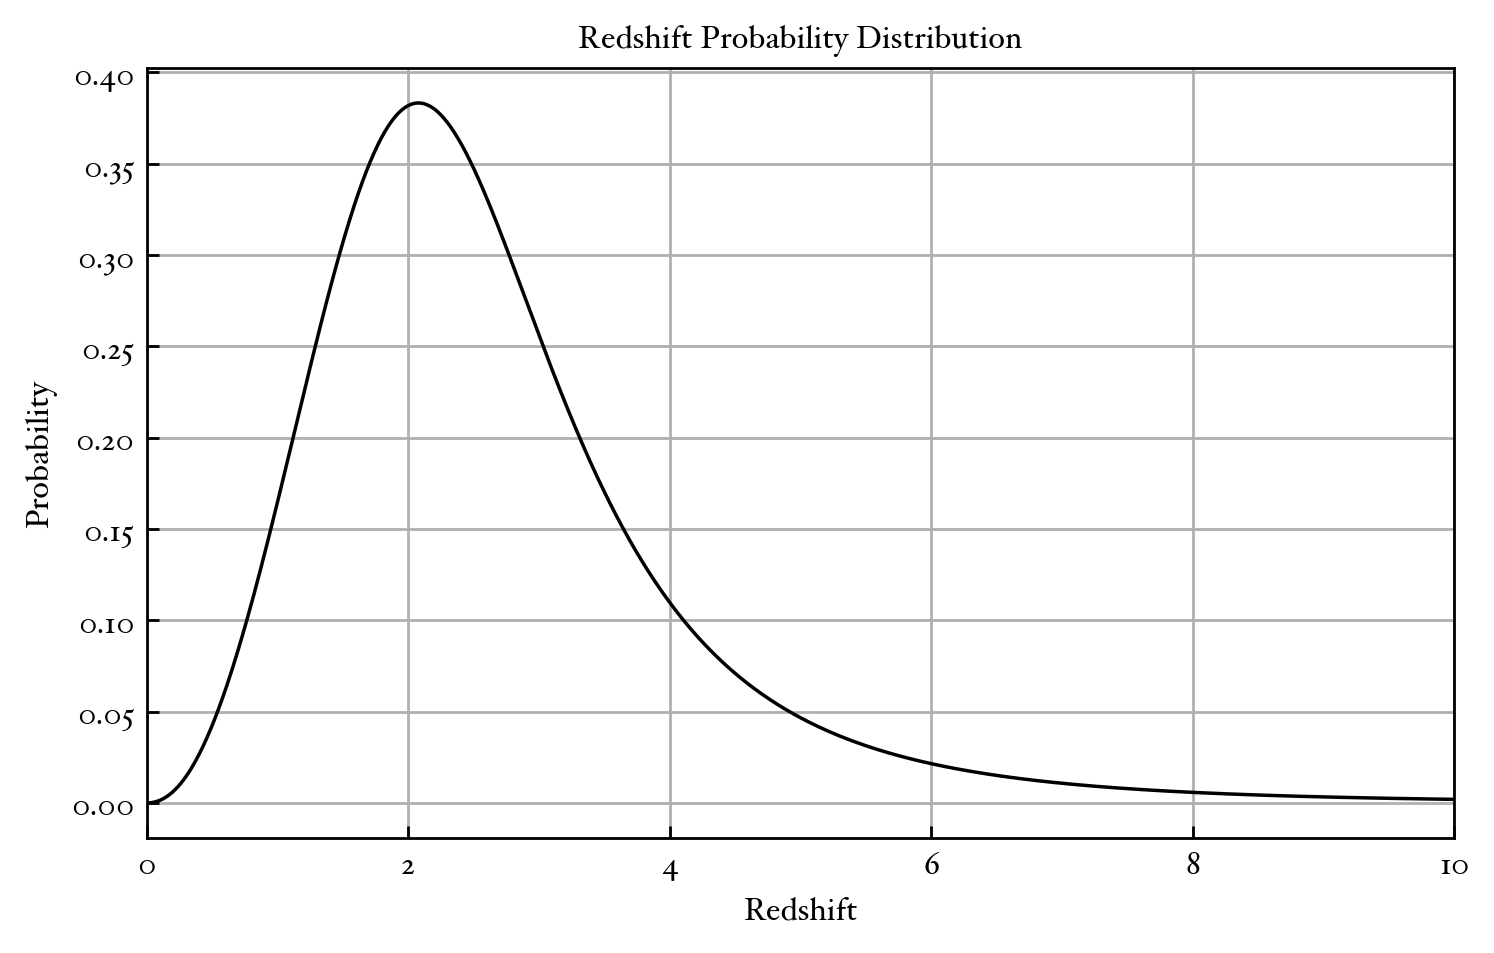

In [20]:
zs = np.linspace(0,10,1000)
fig, ax = plt.subplots()
ax.plot(zs, priors['redshift'].prob(zs), color='#000000')
ax.set_title('Redshift Probability Distribution')
ax.set_xlabel('Redshift')
ax.set_ylabel('Probability')
ax.set_xlim(0,10)
# plt.plot(priors['redshift']._get_redshift_arrays()[0], priors['redshift']._get_redshift_arrays()[1]/priors['redshift']._get_redshift_arrays()[1][0], color='r')